# Prepping Images for Training

If you have the original images and want to preprocess them like I did, just run this notebook!

- I saved some code that visualizes the masks/rectangles at the end of the notebook as Raw NBConvert.
- If you want to visualize the bounding boxes/masks, just turn them back into code cells and run!

In this notebook:

 - I resize the images to 50% of the original size and turn the images into greyscale and save them.
 - I slice the images and masks and save them.
 - I find the coordinates for the rectangles around the masks for each of the kidney images.
 - I create and save a dataframe containing the target cell info of the sliced images.

## Import things

In [1]:
import os
import cv2

import numpy as np
import pandas as pd

import tifffile as tiff
import imutils
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
img_path = '../train/images/'
images = os.listdir(img_path)

mask_path = '../train/masks'

test_path = '../test/images/'

In [3]:
df = pd.read_csv('../CSVs/train.csv')
img_name_list = df['id'].tolist()

In [4]:
df.head()

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
2,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
3,0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
4,e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...


### Make some folders for organization purposes:

In [5]:
# folder for our grey images
try:
    os.mkdir('../train/images/grey')
except FileExistsError:
    pass

In [6]:
# folder for our slices
try:
    os.mkdir('../train/images/slices')
except FileExistsError:
    pass

In [7]:
# folder for our mask images
try:
    os.mkdir('../train/masks')
except FileExistsError:
    pass

In [8]:
# folder for our mask images
try:
    os.mkdir('../train/masks/slices')
except FileExistsError:
    pass

In [9]:
# folder for our test slices
try:
    os.mkdir('../test/images/slices')
except FileExistsError:
    pass

In [10]:
# folder for our test grey images
try:
    os.mkdir('../test/images/grey')
except FileExistsError:
    pass

## Functions

In [11]:
# The source for this function: 
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
# edited to suit my notebook

def rle2mask(img_id):
    '''
    img_id: the id number of image
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    path = os.path.join(img_path, img_id+'.tiff')
    image = tiff.imread(path)
    mask_rle = df[df['id'] == img_id]['encoding'].values[0]
    
    if len(image.shape) == 5:
            image = image.squeeze().transpose(1, 2, 0)
    
    shape=(image.shape[1],image.shape[0])
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [12]:
def resize_img(img_id, scale_percent):
        path = os.path.join(img_path, img_id+'.tiff')
        image = tiff.imread(path)
        if len(image.shape) == 5:
            image = image.squeeze().transpose(1, 2, 0)
        
        width = int(image.shape[1] * scale_percent)
        height = int(image.shape[0] * scale_percent)
        dimensions = (width, height)
        
        resized = cv2.resize(image, dimensions)
        return resized

In [13]:
def resize_masks(image_id, scale):
    maskpath = os.path.join(mask_path, name + '_mask.tiff')
    mask = tiff.imread(maskpath)
    fullpath = os.path.join(img_path, name + '_small.tiff')
    image = tiff.imread(fullpath)
    
    width = int(mask.shape[1] * scale)
    height = int(mask.shape[0] * scale)
    dimensions = (width, height)
    resized = cv2.resize(mask, dimensions)
    return resized

In [14]:
def to_grey(img_id):
    path = os.path.join(img_path, img_id + '.tiff')
    image = tiff.imread(path)
    weights = [0.2989, 0.5870, 0.1140]
    grey_img = np.dot(image, weights)
    return grey_img

In [15]:
# reference: https://stackoverflow.com/questions/53755910/how-can-i-split-a-large-image-into-small-pieces-in-python

def slice_grey(image_id):
    fullpath = os.path.join(img_path + 'grey', image_id + '.tiff')
    image = tiff.imread(fullpath)
    real_id = image_id[:-11]
    
    for r in range(0, image.shape[0], int(image.shape[0]/32)):
        for c in range(0, image.shape[1], int(image.shape[1]/32)):
            cv2.imwrite(f"../train/images/slices/{real_id}_{r}_{c}.tiff", 
                        image[r:r+ int(image.shape[0]/32), c:c+ int(image.shape[1]/32)])
        
    print(f'{image_id} has been sliced')

In [16]:
def slice_masks(image_id):
    path = os.path.join(mask_path, image_id + '.tiff')
    image = tiff.imread(path)
    real_id = image_id[:-11]
    
    for r in range(0, image.shape[0], int(image.shape[0]/32)):
        for c in range(0, image.shape[1], int(image.shape[1]/32)):
            cv2.imwrite(f"../train/masks/slices/{real_id}_{r}_{c}.tiff", 
                        image[r:r+ int(image.shape[0]/32), c:c+ int(image.shape[1]/32)])
            
    print(f'{image_id} has been sliced')

### Take the RLE masks, turn it into an image, save the image

In [65]:
for names in img_name_list:
    mask = rle2mask(names)
    mask_img = Image.fromarray(mask*255)
    fullpath = os.path.join(mask_path, names + '_mask.tiff')
    mask_img.save(fullpath)
    
    print(f'{names} mask has been created')

2f6ecfcdf mask has been created
aaa6a05cc mask has been created
cb2d976f4 mask has been created
0486052bb mask has been created
e79de561c mask has been created
095bf7a1f mask has been created
54f2eec69 mask has been created
1e2425f28 mask has been created


### Resizing the images for training:
The original images were too big for my computer to train on, so I need to make them smaller

In [66]:
# look at sizes:

for name in img_name_list:
    fullpath = os.path.join(img_path, name + '.tiff')
    print(f'{name}: {(os.stat(fullpath).st_size)/(10**9)}gb')

2f6ecfcdf: 1.099638983gb
aaa6a05cc: 0.415610696gb
cb2d976f4: 2.621746032gb
0486052bb: 1.252081321gb
e79de561c: 1.311552288gb
095bf7a1f: 4.464721632gb
54f2eec69: 2.030958288gb
1e2425f28: 2.588556288gb


In [67]:
%%time
for names in img_name_list:
    smaller = resize_img(names, 0.5)
    fullpath = os.path.join(img_path, names + '_small.tiff')
    cv2.imwrite(fullpath,smaller)    
    print(f'{names} resized has been created')

2f6ecfcdf resized has been created
aaa6a05cc resized has been created
cb2d976f4 resized has been created
0486052bb resized has been created
e79de561c resized has been created
095bf7a1f resized has been created
54f2eec69 resized has been created
1e2425f28 resized has been created
Wall time: 3min 19s


In [68]:
# look at results:
for name in img_name_list:
    fullpath = os.path.join(img_path, name + '_small.tiff')
    image = tiff.imread(fullpath)
    print(f'{name}: {(os.stat(fullpath).st_size)/(10**9)} gb, {image.shape}')

2f6ecfcdf: 0.311634376 gb, (15639, 12897, 3)
aaa6a05cc: 0.119453756 gb, (9242, 6506, 3)
cb2d976f4: 0.738905462 gb, (17470, 24774, 3)
0486052bb: 0.368975892 gb, (12892, 17468, 3)
e79de561c: 0.18822158 gb, (8090, 13510, 3)
095bf7a1f: 0.456006072 gb, (19080, 19500, 3)
54f2eec69: 0.195228776 gb, (15220, 11120, 3)
1e2425f28: 0.357730304 gb, (13390, 16110, 3)


### Resize the mask images so that they fit the smaller images

In [69]:
# look at mask shapes:
for name in img_name_list:
    maskpath = os.path.join('../train/masks', name + '_mask.tiff')
    mask = tiff.imread(maskpath)
    print(f'{name}: {mask.shape}')

2f6ecfcdf: (31278, 25794)
aaa6a05cc: (18484, 13013)
cb2d976f4: (34940, 49548)
0486052bb: (25784, 34937)
e79de561c: (16180, 27020)
095bf7a1f: (38160, 39000)
54f2eec69: (30440, 22240)
1e2425f28: (26780, 32220)


In [70]:
%%time
for name in img_name_list:
    small = resize_masks(name, 0.5)
    path = os.path.join('../train/masks', name + '_mask_small.tiff')
    cv2.imwrite(path, small)
    print(f'{name} resized mask has been created')

2f6ecfcdf resized mask has been created
aaa6a05cc resized mask has been created
cb2d976f4 resized mask has been created
0486052bb resized mask has been created
e79de561c resized mask has been created
095bf7a1f resized mask has been created
54f2eec69 resized mask has been created
1e2425f28 resized mask has been created
Wall time: 46 s


In [71]:
# check are the resized masks and images the same shape (not including color)?

for name in img_name_list:
    maskpath = os.path.join('../train/masks', name + '_mask_small.tiff')
    mask = tiff.imread(maskpath)
    fullpath = os.path.join(img_path, name + '_small.tiff')
    image = tiff.imread(fullpath)
    
    print(name, mask.shape== image.shape[0:2])

2f6ecfcdf True
aaa6a05cc True
cb2d976f4 True
0486052bb True
e79de561c True
095bf7a1f True
54f2eec69 True
1e2425f28 True


### Make images greyscale to make them even smaller in filesize

In [72]:
small_names = [i + '_small' for i in img_name_list]
small_names

['2f6ecfcdf_small',
 'aaa6a05cc_small',
 'cb2d976f4_small',
 '0486052bb_small',
 'e79de561c_small',
 '095bf7a1f_small',
 '54f2eec69_small',
 '1e2425f28_small']

In [73]:
for name in small_names:
    grey = to_grey(name)
    grey_path = os.path.join(img_path + 'grey', name +'_grey.tiff')
    cv2.imwrite(grey_path, grey)    
    
    print(f'{name} is grey now')

2f6ecfcdf_small is grey now
aaa6a05cc_small is grey now
cb2d976f4_small is grey now
0486052bb_small is grey now
e79de561c_small is grey now
095bf7a1f_small is grey now
54f2eec69_small is grey now
1e2425f28_small is grey now


### Split each image into smaller tiles

In [74]:
grey_names = [i+'_small_grey' for i in img_name_list]

In [75]:
for name in grey_names:
    slice_grey(name)

2f6ecfcdf_small_grey has been sliced
aaa6a05cc_small_grey has been sliced
cb2d976f4_small_grey has been sliced
0486052bb_small_grey has been sliced
e79de561c_small_grey has been sliced
095bf7a1f_small_grey has been sliced
54f2eec69_small_grey has been sliced
1e2425f28_small_grey has been sliced


### Now I need to slice the masks into the same squares

In [76]:
mask_name = [i+'_mask_small' for i in img_name_list]

In [77]:
for name in mask_name:
    slice_masks(name)

2f6ecfcdf_mask_small has been sliced
aaa6a05cc_mask_small has been sliced
cb2d976f4_mask_small has been sliced
0486052bb_mask_small has been sliced
e79de561c_mask_small has been sliced
095bf7a1f_mask_small has been sliced
54f2eec69_mask_small has been sliced
1e2425f28_mask_small has been sliced


### Not all slices are useful. I only want to keep the slices that contain masks:

In [78]:
mask_slices = os.listdir('../train/masks/slices')

In [79]:
%%time
save_list = []
delete_list =[]

for name in mask_slices:
    path = os.path.join('../train/masks/slices', name)
    image = tiff.imread(path)
    if 255 in image:
        save_list.append(name)
    else:
        delete_list.append(name)

Wall time: 37.6 s


In [80]:
# make sure there's no overlap between the two lists
list(set(save_list) & set(delete_list))

[]

In [81]:
print(f'# save: {len(save_list)}\n# to be deleted: {len(delete_list)}')

# save: 1797
# to be deleted: 6915


In [82]:
%%time

# delete unneccessary images in masks slices folder
for name in delete_list:
    path = os.path.join('../train/masks/slices', name)
    if os.path.isfile(path): 
        os.remove(path)

Wall time: 3.15 s


In [83]:
%%time

# delete unneccessary images from the grey images slices folder
for name in delete_list:
    path = os.path.join('../train/images/slices', name)
    if os.path.isfile(path): 
        os.remove(path)

Wall time: 4.45 s


### Make new csv with the width, height, xmin, ymin, xmax, ymax from all the tiles

In [84]:
save_list = os.listdir('../train/masks/slices')

In [85]:
%%time

contour_list_tiles = []

for name in save_list:
    path = os.path.join('../train/masks/slices', name)
    image = tiff.imread(path)
    
    contours = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    
    for c in contours:
        contour_dict = {}
        x,y,w,h = cv2.boundingRect(c)
        
        contour_dict['filename'] = name
        contour_dict['width'] = w
        contour_dict['height'] = h
        contour_dict['class'] = 'glomeruli'
        contour_dict['xmin'] = x
        contour_dict['ymin'] = y
        contour_dict['xmax'] = x+w
        contour_dict['ymax'] = y+h

        contour_list_tiles.append(contour_dict)

Wall time: 3.41 s


In [86]:
glomeruli_tiles = pd.DataFrame(contour_list_tiles)

In [87]:
glomeruli_tiles.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,0486052bb_10050_3815.tiff,118,123,glomeruli,427,279,545,402
1,0486052bb_10050_4360.tiff,92,125,glomeruli,0,277,92,402
2,0486052bb_10050_4360.tiff,193,167,glomeruli,307,108,500,275
3,0486052bb_10050_4905.tiff,106,79,glomeruli,117,218,223,297
4,0486052bb_10050_4905.tiff,121,126,glomeruli,424,74,545,200


In [88]:
glomeruli_tiles.to_csv('../CSVs/glomeruli_tiles.csv', index=False)

### Resize the test images and make them grey

In [95]:
def resize_test(img_id, scale_percent):
        path = os.path.join('../test/images', img_id+'.tiff')
        image = tiff.imread(path)
        if len(image.shape) == 5:
            image = image.squeeze().transpose(1, 2, 0)
        
        width = int(image.shape[1] * scale_percent)
        height = int(image.shape[0] * scale_percent)
        dimensions = (width, height)
        
        resized = cv2.resize(image, dimensions)
        return resized

In [96]:
def to_grey_test(img_id):
    path = os.path.join('../test/images', img_id + '.tiff')
    image = tiff.imread(path)
    weights = [0.2989, 0.5870, 0.1140]
    grey_img = np.dot(image, weights)
    return grey_img

In [97]:
test_names = os.listdir('../test/images')[:-2]

In [98]:
test_ids = [i[:-5] for i in test_names]

In [99]:
test_ids

['26dc41664', 'afa5e8098', 'b2dc8411c', 'b9a3865fc', 'c68fe75ea']

In [100]:
for name in test_ids:
    smaller = resize_test(name, 0.5)
    fullpath = os.path.join('../test/images', name+ '_small.tiff')
    cv2.imwrite(fullpath, smaller)
    print(f'{name} has been resized')

26dc41664 has been resized
afa5e8098 has been resized
b2dc8411c has been resized
b9a3865fc has been resized
c68fe75ea has been resized


In [101]:
test_small = [i + '_small' for i in test_ids]

In [102]:
for name in test_small:
    grey = to_grey_test(name)
    fullpath = os.path.join('../test/images/grey', name+ '_grey.tiff')
    cv2.imwrite(fullpath, grey)
    print(f'{name} is grey now')

26dc41664_small is grey now
afa5e8098_small is grey now
b2dc8411c_small is grey now
b9a3865fc_small is grey now
c68fe75ea_small is grey now


### Split each test image into smaller tiles

In [103]:
grey_names = [i + '_grey' for i in test_small]

In [104]:
def slice_test(image_id):
    fullpath = os.path.join('../test/images/grey', image_id + '.tiff')
    image = tiff.imread(fullpath)
    real_id = image_id[:-11]
    
    if image.shape[0] < 15000:
        for r in range(0, image.shape[0], int(image.shape[0]/16)):
            for c in range(0, image.shape[1], int(image.shape[1]/16)):
                cv2.imwrite(f"../test/images/slices/{real_id}_{r}_{c}.tiff", image[r:r+ int(image.shape[0]/16), c:c+ int(image.shape[1]/16)])
        
    else:
        for r in range(0, image.shape[0], int(image.shape[0]/32)):
            for c in range(0, image.shape[1], int(image.shape[1]/32)):
                cv2.imwrite(f"../test/images/slices/{real_id}_{r}_{c}.tiff", image[r:r+ int(image.shape[0]/32), c:c+ int(image.shape[1]/32)])
    print(f'{image_id} has been sliced')

In [105]:
for name in grey_names:
    slice_test(name)

26dc41664_small_grey has been sliced
afa5e8098_small_grey has been sliced
b2dc8411c_small_grey has been sliced
b9a3865fc_small_grey has been sliced
c68fe75ea_small_grey has been sliced


### Everything is prepped now, time to model :D

### Some extra code:

### Load in one of the new image masks, find contours, making bounding rectangle, and visualize the rectangles 
If you want to visualize the masks, turn the cells back into code cells and run

### Load in the new image masks, find contours, make dictionary with width, height, xmin, ymin, xmax, ymax, put dictionary in list
If you want a CSV of the masks of the originals, turn these cells back into code cells and run

### Zoomed in overlay mask and image

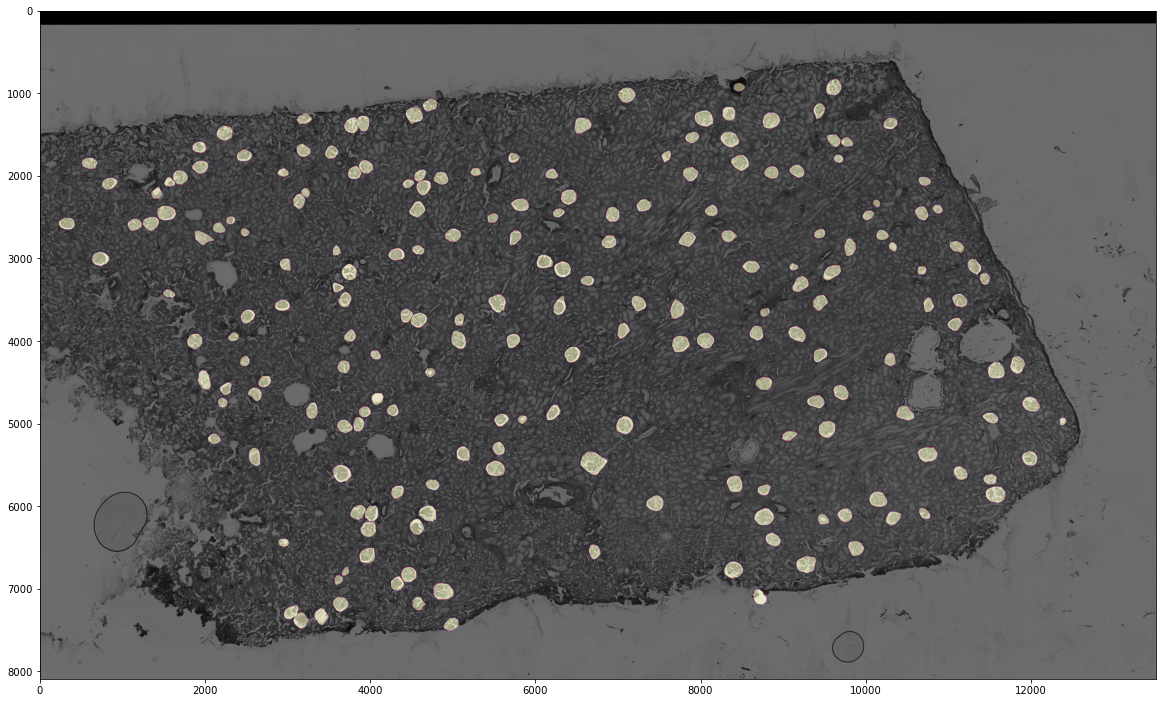

In [5]:
plt.figure(figsize=[20,20])

fullpath = os.path.join('../train/images/grey', 'e79de561c_small_grey.tiff')
image = tiff.imread(fullpath)

path = os.path.join('../train/masks', 'e79de561c_mask_small.tiff')
mask = tiff.imread(path)

plt.imshow(image, cmap='gray')
plt.imshow(mask, cmap='magma', alpha=0.5)